The purpose of this notebook is testing the most naive fast style transfer approach that I coin up - autoencoder.<br>
I prepared 15 pairs of images with the same style donor, it was the Vincent van Gogh`s "The Starry Night".

In [0]:
from keras import layers
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, ReLU

from keras.models import Model, load_model,  model_from_json
from keras import backend as K 

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

import numpy as np
np.random.seed(42) # for reproducibility

import matplotlib.pyplot as plt

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

import os

from google.colab.patches import cv2_imshow   #instead of cv2.imshow
import cv2

### Setting up model

The structure of this autoencoder was taken from the article [Perceptual Losses for Real-Time Style Transfer
and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)

In [0]:
def residual_block(y, nb_channels, _strides = (1, 1)):
  shortcut = y

  #forward pass
  y = Conv2D(nb_channels, kernel_size = (3, 3), strides = _strides, padding = 'same')(y)
  y = BatchNormalization()(y)
  y = ReLU()(y)

  y = Conv2D(nb_channels, kernel_size = (3, 3), strides = _strides, padding = 'same')(y)
  y = BatchNormalization()(y)

  #adding shortcut
  y = layers.add([shortcut, y])
  y = ReLU()(y)

  return y

In [19]:
input_img = Input(shape = (512, 512, 3)) # 512 (not 256) because all of our train style images have higth = 400 px

x = Conv2D(32, (9, 9), strides = 1, activation = 'relu', padding = 'same')(input_img)
x = Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
print('Shape after encoding:', x.shape)

x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
x = residual_block(x, 128, (1, 1))
print('Shape after residual blocks:', x.shape)

x = Conv2DTranspose(64, (3, 3), strides = 2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides = 2, activation='relu', padding='same')(x)
decoded = Conv2DTranspose(3, (9, 9), strides = 1, activation='relu', padding='same')(x) #may be sigmoid function?
print('Shape after decoding:', decoded.shape)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Shape after encoding: (?, 128, 128, 128)
Shape after residual blocks: (?, 128, 128, 128)
Shape after decoding: (?, ?, ?, 3)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Preparing Data

**Image generators**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# we have different input (original picture) and output (styletransfered picture) for our training set
train_input_dir = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/original_images'
train_output_dir = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/generated_results'
test_dir = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images'

In [0]:
# templates for our future image generators
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )

test_datagen = ImageDataGenerator(rescale = 1./255)

In [0]:
train_input_generator = train_datagen.flow_from_directory(
    train_input_dir,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = None,
    seed = 42) #dix seed to get pairs of images

train_output_generator = train_datagen.flow_from_directory(
    train_output_dir,
    target_size = (512, 512),
    batch_size = 32,
    class_mode = None,
    seed = 42)

Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


In [0]:
def pairs_generator(input_generator, output_generator):
  for batch_pair in zip(input_generator, output_generator):
    yield batch_pair 


In [0]:
# Check image generators

https://github.com/keras-team/keras/issues/3386

In [0]:
sample = next(pairs_generator(train_input_generator, train_output_generator))

(15, 512, 512, 3)


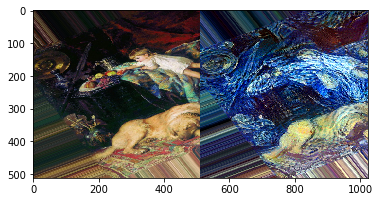

In [0]:
imgs_1 = sample[0]
imgs_2 = sample[1]
print(imgs_1.shape)
plt.imshow(np.hstack([imgs_1[0, :, :, :], imgs_2[0, :, :, :]]))
plt.show()

### Train model

In [0]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://4a52f608.ngrok.io


In [0]:
def train_model():
  '''
  Safety wrapper for model training
  '''
  autoencoder.fit_generator(pairs_generator(train_input_generator, train_output_generator),
                  steps_per_epoch = 100,
                  nb_epoch = 10,
                  callbacks = [TensorBoardColabCallback(tbc)])
  return autoencoder

In [0]:
# # Uncomment to re-train model
# autoencoder = train_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=100, callbacks=[<tensorbo..., epochs=10)`
  






Epoch 1/10
100/100 [==============================] - 282s 3s/step - loss: 0.7379

Epoch 2/10
100/100 [==============================] - 269s 3s/step - loss: 0.6109
Epoch 3/10
100/100 [==============================] - 282s 3s/step - loss: 0.6158
Epoch 4/10
100/100 [==============================] - 286s 3s/step - loss: 0.6027
Epoch 5/10
100/100 [==============================] - 285s 3s/step - loss: 0.5994
Epoch 6/10
100/100 [==============================] - 277s 3s/step - loss: 0.5941
Epoch 7/10
100/100 [==============================] - 272s 3s/step - loss: 0.5927
Epoch 8/10
100/100 [==============================] - 267s 3s/step - loss: 0.5898
Epoch 9/10
100/100 [==============================] - 268s 3s/step - loss: 0.5863
Epoch 10/10
100/100 [==============================] - 267s 3s/step - loss: 0.5856


In [0]:
#save results
def save_model(model_name = 'style_autoencoder'):
  json_model = autoencoder.to_json()
  
  save_dir = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/saved_models'

  with open(os.path.join(save_dir, '{}.json'.format(model_name)), 'w') as json_file:
    json_file.write(json_model)
  autoencoder.save(os.path.join(save_dir, '{}_weights.h5'.format(model_name)))

In [0]:
# # Uncomment to save trained model
# save_model(model_name = 'style_autoencoder_512')

### Load pre-trained model
Start here if you just want to get results

**Load model**

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
model_files_dir = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/saved_models'

In [0]:
def load_model(json_file_name, h5_file_name):
  json_file = open(os.path.join(model_files_dir, json_file_name), 'r')
  model_json = json_file.read()
  json_file.close()

  model = model_from_json(model_json)
  model.load_weights(os.path.join(model_files_dir, h5_file_name))

  return model

In [0]:
autoencoder = load_model('style_autoencoder_512.json', 'style_autoencoder_512_weights.h5')

**Get test results**

In [0]:
# Get list of names of all test images
test_images_names = os.listdir(os.path.join(test_dir, 'dummy_folder'))
print(test_images_names)


['balanced_stones.jpg', 'branches.jpg', 'forest.jpg', 'stones.jpeg', 'bridge.jpg', 'red_bridge.png', 'smoggy_forest.jpg', 'car.jpg', 'sky_bridge.jpg']


In [0]:
# Make dict with test files pathes
test_images_dict = {}
test_images_path = os.path.join(test_dir, 'dummy_folder')

for dirpath, _, filenames in os.walk(test_images_path):
  for f in filenames:
    test_images_dict[f] = os.path.abspath(os.path.join(dirpath, f))
test_images_dict

{'balanced_stones.jpg': '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images/dummy_folder/balanced_stones.jpg',
 'branches.jpg': '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images/dummy_folder/branches.jpg',
 'bridge.jpg': '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images/dummy_folder/bridge.jpg',
 'car.jpg': '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images/dummy_folder/car.jpg',
 'forest.jpg': '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images/dummy_folder/forest.jpg',
 'red_bridge.png': '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images/dummy_folder/red_bridge.png',
 'sky_bridge.jpg': '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_images/dummy_folder/sky_bridge.j

In [0]:
def make_picture(picture_name, saving_dir_path = None):
  try:
    picture_path = test_images_dict[picture_name]
  except:
    raise ValueError('Can`t find this file in folder!')

  original_img = cv2.imread(picture_path) 
  original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) #BGR -> RGB

  height, width, _ = original_img.shape
  #print('Original image size:', height, width)

  output_img_height = 400         #width size of any styled image from train set
  output_img_width = int(width * (output_img_height/height))
  #print('Scaled image size:', output_img_height, output_img_width)

  scaled_original_img = cv2.resize(original_img, (output_img_width, output_img_height))

  input_img = cv2.resize(original_img, (512, 512))/255 
  input_img = np.expand_dims(input_img, axis = 0)

  output_img = autoencoder.predict(input_img)
  output_img = cv2.resize(output_img[0], (output_img_width, output_img_height))

  fig, axs = plt.subplots(1, 2, figsize = (10, 5))
  fig.suptitle('Original and encoded pictures')
  axs[0].imshow(scaled_original_img)
  axs[1].imshow(output_img)

  if saving_dir_path is not None:
    plt.imsave(os.path.join(saving_dir_path, picture_name), np.clip(output_img, 0, 1))
    
  return None

In [0]:
save_results_dir = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/img_encoders_pairs/test_results'

In [31]:
for img_name in test_images_dict.keys():
  make_picture(img_name, save_results_dir)

Output hidden; open in https://colab.research.google.com to view.